In [1]:
import json
import os
from datetime import datetime, timedelta
import pandas as pd
from mmengine.config import Config

In [2]:
current_dir = os.getcwd()

def listdir(*rel_paths):
    return os.listdir(os.path.join(current_dir, *rel_paths))

def isdir(*rel_paths):
    return os.path.isdir(os.path.join(current_dir, *rel_paths))

def join(*rel_paths):
    return os.path.join(current_dir, *rel_paths)

def isfile(*rel_paths):
    return os.path.isfile(join(*rel_paths))


def get_log_runs():
    work_dirs = [d for d in os.listdir() if isdir(d)]
    print(f'work dirs: {len(work_dirs)}')
    log_runs = [(work_dir, d) for work_dir in work_dirs for d in listdir(work_dir) if isdir(work_dir,d)]
    print(f'log runs: {len(log_runs)}')
    return log_runs


def started_train_run(work_dir, d):
    return isfile(work_dir, d, 'vis_data', f'{d}.json')

def get_logs_df():
    log_runs = get_log_runs()
    return pd.DataFrame(log_runs, columns=['work_dir', 'log_run'])

I want to get the following information, if possible:
- filter for train runs, not test
- config contents
    - model
        - hyperparameters (batch size, learning rate, weight decay, momentum, prompt depth)
    - dataset

- total time spent during training
- percentage of trainable parameters
    - trainable parameters
    - total parameters
- for training runs:
    - training curve
    - validation curve
    - memory profile
    - whether there is a corresponding test run?
- for test runs:
    - test results
    - test mode (slide or whole)

In [7]:
def load_config(logs_row):
    return Config.fromfile(join(logs_row['work_dir'], logs_row['log_run'], 'config.py'))

def extract_pretrain_config_info(logs):
    def get_checkpoint(row):
        if row['config'].model.backbone.init_cfg.type == 'Pretrained':
            return row['config'].model.backbone.init_cfg.checkpoint
        return None
    def get_load_from(row):
        return row['config'].load_from
    logs['checkpoint'] = logs.apply(get_checkpoint, axis=1)
    logs['load_from'] = logs.apply(get_load_from, axis=1)
    return logs

def extract_prompt_config_info(logs):
    logs['prompt_depth'] = logs.apply(lambda row: row['config'].model.backbone.prompt_cfg.depth if row['backbone'] == 'PromptedVisionTransformer' else None, axis=1)
    logs['prompt_length'] = logs.apply(lambda row: row['config'].model.backbone.prompt_cfg.length if row['backbone'] == 'PromptedVisionTransformer' else None , axis=1)
    logs['prompt_dropout'] = logs.apply(lambda row: row['config'].model.backbone.prompt_cfg.dropout if row['backbone'] == 'PromptedVisionTransformer' else None, axis=1)
    return logs

def extract_memory_file(logs):
    memory_files = logs.apply(lambda row: join(row['work_dir'], row['log_run'], 'memory_snapshot.pickle'), axis=1)
    logs['memory_file'] = memory_files.apply(lambda path: path if isfile(path) else None)
    return logs
    
def extract_config_info(logs):
    configs = logs_df.apply(load_config, axis=1)
    logs_df['config'] = configs
    logs['backbone'] = configs.apply(lambda config: config.model.backbone.type)
    logs['pretrained'] = configs.apply(lambda config: config.model.backbone.init_cfg.type == 'Pretrained')
    logs = extract_pretrain_config_info(logs)
    logs['auxhead'] = configs.apply(lambda config: len(config.model.auxiliary_head) > 0)
    logs['train_dataset'] = configs.apply(lambda config: config.train_dataloader.dataset.type)
    logs['train_iters'] = configs.apply(lambda config: config.train_cfg.max_iters)
    logs['test_dataset'] = configs.apply(lambda config: config.test_dataloader.dataset.type)
    logs['test_mode'] = configs.apply(lambda config: config.model.test_cfg.mode)
    logs['batch_size'] = configs.apply(lambda config: config.train_dataloader.batch_size)
    logs['learning_rate'] = configs.apply(lambda config: config.optimizer.lr)
    logs['weight_decay'] = configs.apply(lambda config: config.optimizer.weight_decay)
    logs['momentum'] = configs.apply(lambda config: config.optimizer.momentum)
    logs = extract_prompt_config_info(logs)
    logs = extract_memory_file(logs)
    logs = logs.drop(columns=['config'])
    return logs


def readlogs(row):
    with open(join(row['work_dir'], row['log_run'], f'{row["log_run"]}.log'), 'r') as f:
        return f.readlines()

def extract_total_parameters(log_contents):
    for line in log_contents:
        if 'Total parameters' in line:
            return int(line.split('Total parameters: ')[1].strip())
    return None

def extract_trainable_parameters(log_contents):
    for line in log_contents:
        if 'Trainable parameters' in line:
            return int(line.split('Trainable parameters: ')[1].strip())
    return None

def extract_time_at_index(log_contents, index):
    line = log_contents[index]
    return datetime.strptime(line.split('- mmengine -')[0].strip(), '%Y/%m/%d %H:%M:%S')

def extract_start_time(log_contents):
    return extract_time_at_index(log_contents, 0)

def extract_end_time(log_contents):
    return extract_time_at_index(log_contents, -1)

def extract_log_info(logs):
    log_contents = logs.apply(readlogs, axis=1)
    logs['total_parameters'] = log_contents.apply(extract_total_parameters)
    logs['trainable_parameters'] = log_contents.apply(extract_trainable_parameters)
    logs['trainable_parameters_percentage'] = logs['trainable_parameters'] / logs['total_parameters']
    logs['duration'] = log_contents.apply(extract_end_time) - log_contents.apply(extract_start_time)
    return logs

def get_train_run_info(row):
    with open(join(row['work_dir'], row['log_run'], 'vis_data', f'{row["log_run"]}.json'), 'r') as f:
        lines = f.readlines()
        parsed_lines = [json.loads(line) for line in lines]
        return [line for line in parsed_lines if line.get('loss') is not None]

def get_val_run_info(row):
    with open(join(row['work_dir'], row['log_run'], 'vis_data', f'{row["log_run"]}.json'), 'r') as f:
        lines = f.readlines()
        parsed_lines = [json.loads(line) for line in lines]
        return [line for line in parsed_lines if line.get('loss') is None]

def get_test_run_info(row):
    if not isdir(row['work_dir'], row['log_run'], 'test'):
        return None
    tests = listdir(row['work_dir'], row['log_run'], 'test')
    if len(tests) == 0:
        return None
    if len(tests) > 1:
        raise ValueError(f'WARNING: more than one test run found for {row["log_run"]}')
    test = tests[0]
    with open(join(row['work_dir'], row['log_run'], 'test', test, f'{test}.json'), 'r') as f:
        lines = f.readlines()
        assert len(lines) == 1
    return json.loads(lines[0])

def extract_run_info(logs):
    train_run_info = logs.apply(get_train_run_info, axis=1)
    val_run_info = logs.apply(get_val_run_info, axis=1)
    test_run_info = logs.apply(get_test_run_info, axis=1)
    logs['train_run_info'] = train_run_info
    logs['val_run_info'] = val_run_info
    logs['test_run_info'] = test_run_info
    return logs

#todo: also extract per class test results
    

logs_df = get_logs_df()
logs_df = extract_config_info(logs_df)
logs_df = extract_log_info(logs_df)
logs_df = extract_run_info(logs_df)
logs_df = logs_df.sort_values(by=['backbone'])
display(logs_df)

work dirs: 6
log runs: 8


,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,...,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info
3,setrvpt_vit-l_pup-noaux_8xb2-160k_ade20k-512x512,20231125_124611,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,None,False,ADE20KDataset,160000,ADE20KDataset,...,50.0,0.1,None,309546646.0,5400214.0,0.017446,3 days 06:57:31,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 75.02, 'mIoU': 17.12, 'mAcc': 23.44,...","{'aAcc': 80.87, 'mIoU': 42.8, 'mAcc': 55.02, '..."
4,setrvpt_vit-l_pup-noaux_8xb2-160k_ade20k-512x512,20231208_113210,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,None,False,ADE20KDataset,160000,ADE20KDataset,...,50.0,0.1,None,309546646.0,5400214.0,0.017446,1 days 16:37:39,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 73.97, 'mIoU': 15.11, 'mAcc': 21.0, ...","{'aAcc': 80.41, 'mIoU': 41.2, 'mAcc': 55.12, '..."
6,setrvpt_vit-l_pup_8xb2-160k_ade20k-512x512,20231120_011426,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,None,True,ADE20KDataset,160000,ADE20KDataset,...,50.0,0.1,None,NaN,NaN,NaN,2 days 05:50:09,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 73.44, 'mIoU': 13.78, 'mAcc': 19.44,...","{'aAcc': 80.94, 'mIoU': 40.55, 'mAcc': 52.68, ..."
0,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231207_151546,VisionTransformer,True,pretrain/vit_large_p16.pth,None,True,CBISBinaryDataset,160000,CBISBinaryDataset,...,NaN,NaN,/home/drumsnchocolate/Documents/Studie/Master/...,317137928.0,317137928.0,1.000000,1 days 16:32:56,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 98.35, 'mIoU': 52.42, 'mAcc': 53.91,...","{'aAcc': 98.1, 'mIoU': 53.54, 'mAcc': 57.14, '..."
1,setr_vit-l_pup-noaux_8xb2-160k_ade20k-512x512,20231119_220357,VisionTransformer,True,pretrain/vit_large_p16.pth,None,False,ADE20KDataset,160000,ADE20KDataset,...,NaN,NaN,None,NaN,NaN,NaN,3 days 02:53:09,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 79.64, 'mIoU': 40.66, 'mAcc': 53.44,...","{'aAcc': 82.32, 'mIoU': 48.14, 'mAcc': 60.29, ..."
2,setr_vit-l_pup-noaux_8xb2-160k_ade20k-512x512,20231208_113210,VisionTransformer,True,pretrain/vit_large_p16.pth,None,False,ADE20KDataset,160000,ADE20KDataset,...,NaN,NaN,None,308317846.0,308317846.0,1.000000,1 days 15:20:52,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 76.3, 'mIoU': 33.94, 'mAcc': 47.9, '...","{'aAcc': 82.08, 'mIoU': 46.88, 'mAcc': 59.49, ..."
5,setr_vit-l_pup_8xb2-160k_cbis-ddsm-multi-512x512,20231210_162546,VisionTransformer,True,pretrain/vit_large_p16.pth,None,True,CBISBinaryDataset,160000,CBISBinaryDataset,...,NaN,NaN,None,317141012.0,317141012.0,1.000000,0 days 00:16:56,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...",[],None
7,setr_vit-l_pup_8xb2-160k_ade20k-512x512,20231119_220403,VisionTransformer,True,pretrain/vit_large_p16.pth,None,True,ADE20KDataset,160000,ADE20KDataset,...,NaN,NaN,None,NaN,NaN,NaN,2 days 04:13:26,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 76.92, 'mIoU': 32.62, 'mAcc': 43.89,...","{'aAcc': 82.2, 'mIoU': 46.68, 'mAcc': 59.55, '..."


# Displaying training curves, test results

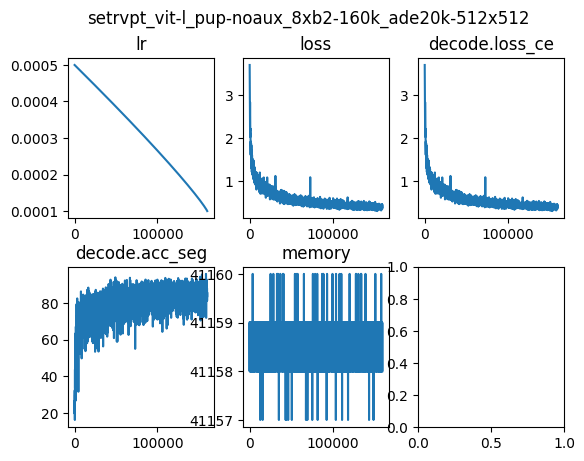

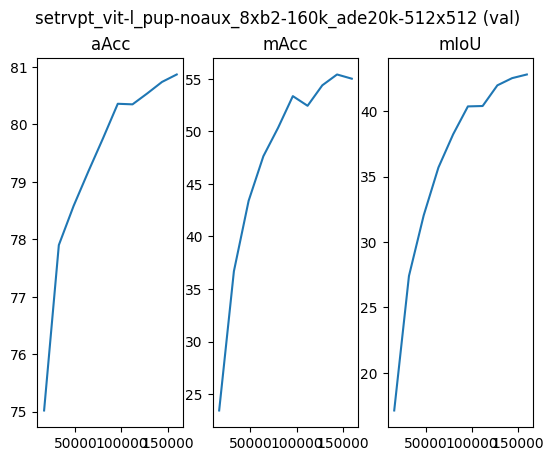

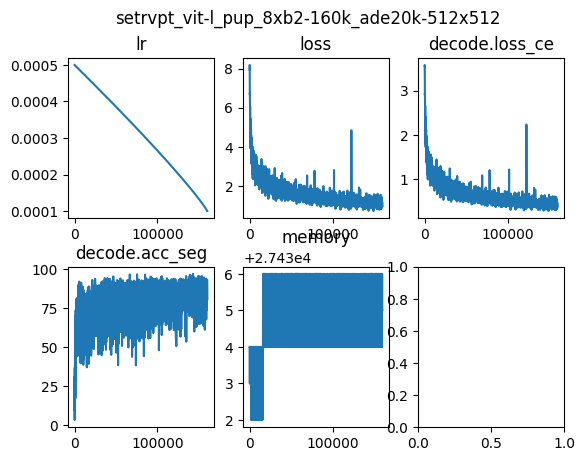

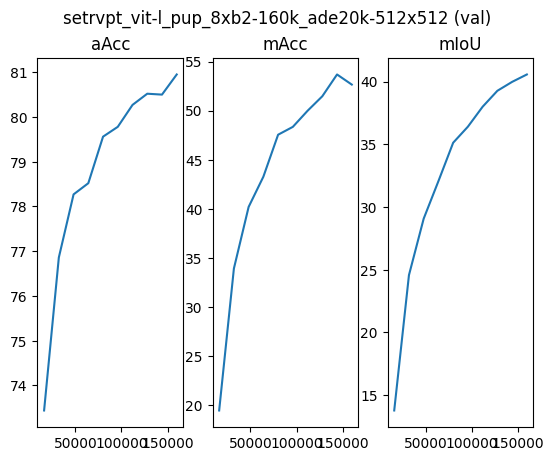

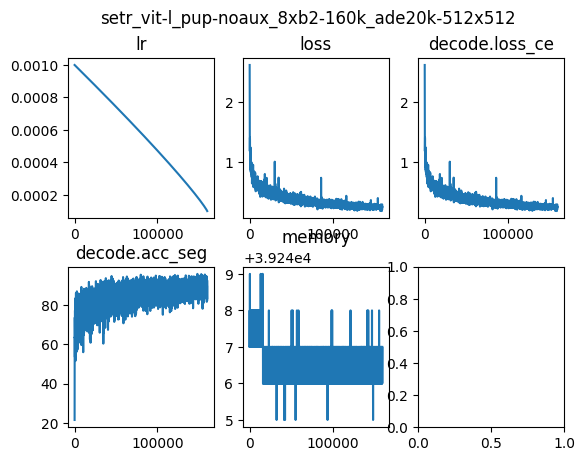

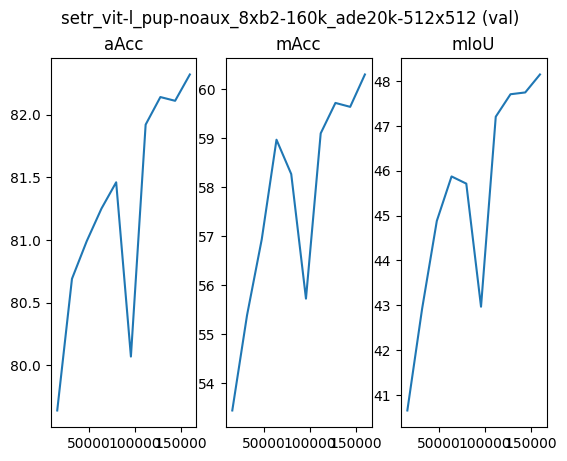

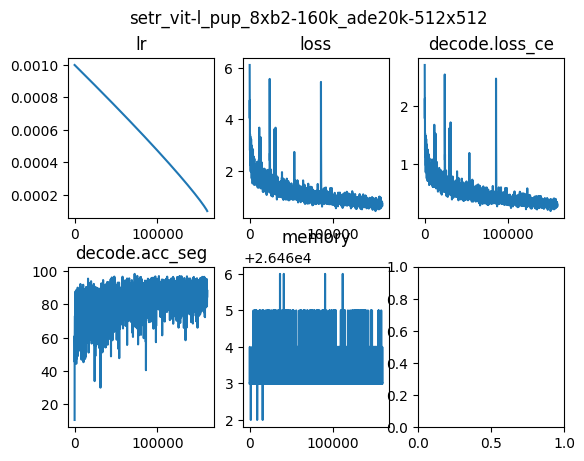

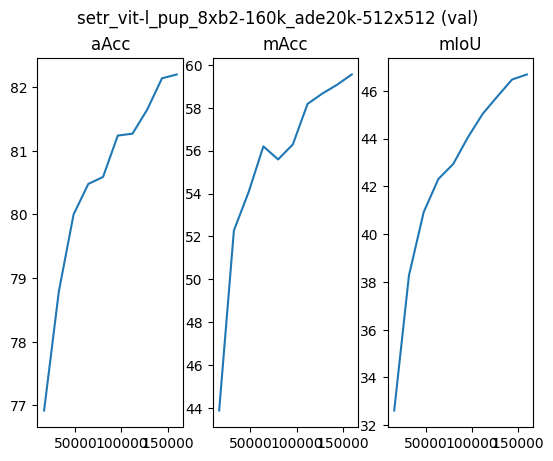

1    None
2    None
0    None
3    None
dtype: object

In [20]:
# first, we plot a training curve for each run
import matplotlib.pyplot as plt
import numpy as np

def plot_train_run_info(row):
    train_run_info = row['train_run_info']
    train_df = pd.DataFrame(train_run_info)
    # let's just plot the following columns out of curiosity:
    # lr, loss, decode.loss_ce, decode.acc_seg, memory\
    fig, axes = plt.subplots(nrows=2, ncols=3, gridspec_kw={"hspace": 0.3})
    fig.suptitle(row['work_dir'])
    for i, c in enumerate(['lr', 'loss', 'decode.loss_ce', 'decode.acc_seg', 'memory']):
        ax = axes[i//3, i%3]
        ax.plot(train_df['step'], train_df[c])
        ax.set_title(c)
    plt.show()

def plot_val_run_info(row):
    val_run_info = row['val_run_info']
    val_df = pd.DataFrame(val_run_info)
    # let's just plot the following columns out of curiosity:
    # aAcc, mAcc, mIoU
    fig, axes = plt.subplots(nrows=1, ncols=3, gridspec_kw={"hspace": 0.3})
    fig.suptitle(f'{row["work_dir"]} (val)')
    for i, c in enumerate(['aAcc', 'mAcc', 'mIoU']):
        ax = axes[i]
        ax.plot(val_df['step'], val_df[c])
        ax.set_title(c)
    plt.show()
    
def plot_run_info(row):
    plot_train_run_info(row)
    plot_val_run_info(row)

logs_df.apply(plot_run_info, axis=1)

In [65]:
def parse_train_line(line):
    parsed_line = {}
    t_str = line.split('- mmengine -')[0].strip()
    t = datetime.strptime(t_str, '%Y/%m/%d %H:%M:%S')
    iteration_str = line.split('Iter(train) [')[1].split(']')[0].strip().split('/')[0]
    iteration = int(iteration_str)
    
    parsed_line['at_iteration'] = iteration
    parsed_line['time'] = t
    parsed_line['type'] = 'train'
    return parsed_line
    

def parse_val_line(line):
    parsed_line = {}
    t_str = line.split('- mmengine -')[0].strip()
    t = datetime.strptime(t_str, '%Y/%m/%d %H:%M:%S')
    iteration_str = line.split('Iter(val) [')[1].split(']')[0].strip().split('/')[0]
    iteration = int(iteration_str)
    
    parsed_line['at_iteration'] = iteration
    parsed_line['time'] = t
    parsed_line['type'] = 'val'
    return parsed_line

def calculate_time_after(parsed_lines):
    for i, line in enumerate(parsed_lines):
        line['duration_after'] = timedelta(0)
        if i < len(parsed_lines) - 1:
            line['duration_after'] = parsed_lines[i+1]['time'] - line['time']

def calculate_time_before(parsed_lines):
    for i, line in enumerate(parsed_lines):
        line['duration_before'] = timedelta(0)
        if i > 0:
            line['duration_before'] = line['time'] - parsed_lines[i-1]['time']
        
def calculate_inbetween_times(parsed_lines):
    calculate_time_after(parsed_lines)
    calculate_time_before(parsed_lines)

def calculate_iterations_per_line(parsed_lines):
    for i, line in enumerate(parsed_lines):
        if i > 0 and line['type'] == parsed_lines[i-1]['type']:
            line['iterations'] = line['at_iteration'] - parsed_lines[i-1]['at_iteration']
            continue
        line['iterations'] = line['at_iteration']

def calculate_duration_per_iteration(parsed_lines):
    for line in parsed_lines:
        line['duration_per_iteration'] = line['duration_before'] / line['iterations']        
    

def parse_logfile(rel_log_path):
    parsed_lines = []
    train_pattern = "Iter(train)"
    val_pattern = "Iter(val)"
    with open(os.path.join(current_dir, rel_log_path), 'r') as f:
        lines = f.readlines()
        for line in lines:
            parsed_line = None
            if train_pattern in line:
                parsed_line = parse_train_line(line)
            if val_pattern in line:
                parsed_line = parse_val_line(line)
            if parsed_line is None:
                continue
            parsed_lines.append(parsed_line)
    # for now, let's filter out lines that report the same iteration as a previous line
    parsed_lines = [parsed_line for i, parsed_line in enumerate(parsed_lines) if i == 0 or parsed_line['at_iteration'] != parsed_lines[i-1]['at_iteration']]
    calculate_inbetween_times(parsed_lines)
    calculate_iterations_per_line(parsed_lines)
    calculate_duration_per_iteration(parsed_lines)
    return parsed_lines
            
parsed_logfiles = {}
for logfile in logfiles:
    parsed_logfiles[logfile] = parse_logfile(logfile)
    


In [66]:

for logfile in logfiles:
    parsed_logfile = parsed_logfiles[logfile]
    if len(parsed_logfile) == 0:
        continue
    df = pd.DataFrame(parsed_logfiles[logfile])
    display(df)
    aggregate_df = df.groupby('type').agg({'duration_after': ['sum', 'mean', 'std'], 'duration_before': ['sum', 'mean', 'std'], 'iterations': ['sum', 'mean', 'std'], 'duration_per_iteration': ['mean', 'std']})
    display(aggregate_df)

    # percentage of time spent on training vs validation:
    print('percentage of time spent on training vs validation:')
    print(aggregate_df['duration_before']['sum'] / aggregate_df['duration_before']['sum'].sum())


,at_iteration,time,type,duration_after,duration_before,iterations,duration_per_iteration
0,50,2023-10-23 14:02:39,train,0 days 00:00:57,0 days 00:00:00,50,0 days 00:00:00
1,100,2023-10-23 14:03:36,train,0 days 00:00:58,0 days 00:00:57,50,0 days 00:00:01.140000
2,150,2023-10-23 14:04:34,train,0 days 00:00:57,0 days 00:00:58,50,0 days 00:00:01.160000
3,200,2023-10-23 14:05:31,train,0 days 00:00:56,0 days 00:00:57,50,0 days 00:00:01.140000
4,250,2023-10-23 14:06:27,train,0 days 00:00:57,0 days 00:00:56,50,0 days 00:00:01.120000
...,...,...,...,...,...,...,...
3295,300,2023-10-25 16:54:35,val,0 days 00:00:06,0 days 00:00:08,50,0 days 00:00:00.160000
3296,350,2023-10-25 16:54:41,val,0 days 00:00:08,0 days 00:00:06,50,0 days 00:00:00.120000
3297,400,2023-10-25 16:54:49,val,0 days 00:00:07,0 days 00:00:08,50,0 days 00:00:00.160000
3298,450,2023-10-25 16:54:56,val,0 days 00:00:07,0 days 00:00:07,50,0 days 00:00:00.140000


duration_after                                                      \
                  sum                      mean                       std   
type                                                                        
train 2 days 02:32:47 0 days 00:00:56.864687500 0 days 00:00:02.158056626   
val   0 days 00:19:37    0 days 00:00:11.770000 0 days 00:00:14.779767087   

      duration_before                                                   \
                  sum                   mean                       std   
type                                                                     
train 2 days 02:38:12 0 days 00:00:56.966250 0 days 00:00:01.182390725   
val   0 days 00:14:12 0 days 00:00:08.520000 0 days 00:00:04.083670363   

      iterations                        duration_per_iteration  \
             sum   mean          std                      mean   
type                                                             
train     880000  275.0  4770.375918 0 days 00:00:01.136046960   
val         5000   50.0     0.000000    0 days 00:00:00.170400   

                                 
                            std  
type                             
train 0 days 00:00:00.064732105  
val   0 days 00:00:00.081673407

percentage of time spent on training vs validation:
type
train    0.995348
val      0.004652
Name: sum, dtype: float64
